# Imports

In [1]:
from utils.gui import interactive_segmentation_with_config

In [5]:
interactive_segmentation_with_config()

Using processing mode from config: ramified
Loaded configuration from checkpoint at step 3
Loaded stack with shape (189, 1536, 1536)
Loaded initial segmentation from checkpoint with 107 objects
Loaded refined ROIs from checkpoint
Loaded feature data and connections from checkpoint
Analysis complete: 118 ramified cells analyzed


100%|██████████| 119/119 [01:34<00:00,  1.26it/s]

Loaded saved configuration parameters


In [2]:
import os
import pandas as pd

def organize_processing_dir(drctry, mode):
    """
    A function to organize the directory with multiple samples for processing with 3D segmentation
    Inputs:
    - drctry: the directory containing tif files and a single csv file with the mapping of x,y,z dimensions to the corresponding tif files; csv file should have columns: 
    Filename, Width (um), Height (um), Slices, Depth (um)

    -mode: 'nuclear' or 'ramified', determines which config template to use
    """
    mode= 'ramified'
    #Make a list of all the tif files in the directory
    tif_files = [f for f in os.listdir(drctry) if f.endswith('.tif')]
    #Make a list of all the csv files in the directory
    csv_files = [f for f in os.listdir(drctry) if f.endswith('.csv')]
    #Check that there is only one csv file in the directory
    if len(csv_files) != 1:
        raise ValueError('There should be only one csv file in the directory')
    #Load the csv file
    csv_file = csv_files[0]
    csv_path = os.path.join(drctry, csv_file)
    df = pd.read_csv(csv_path)
    #Check that the csv file has the correct columns
    if not all([col in df.columns for col in ['Filename', 'Width (um)', 'Height (um)', 'Slices', 'Depth (um)']]):
        raise ValueError('The csv file should have columns: Filename, Width (um), Height (um), Slices, Depth (um)')
    #Check that the csv file has the correct number of rows
    if len(df) != len(tif_files):
        print(len(df), len(tif_files))
        print(tif_files)
        raise ValueError('The csv file should have the same number of rows as the number of tif files in the directory')
    #Create a new directory for each tif file
    root_names = [f.split('.')[0] for f in tif_files]
    for root_name in root_names:
        new_dir = os.path.join(drctry, root_name)
        os.makedirs(new_dir, exist_ok=True)
        #Move the tif file to the new directory
        tif_file = root_name + '.tif'
        tif_path = os.path.join(drctry, tif_file)
        new_tif_path = os.path.join(new_dir, tif_file)
        os.rename(tif_path, new_tif_path)
        
        #Copy the correct yaml config file to the new directory
        if mode == 'nuclear':
            config_file = 'nuclear_config.yaml'
        elif mode == 'ramified':
            config_file = 'ramified_config.yaml'
        #Template config is in the same directory as this script
        config_path = config_file
        new_config_path = os.path.join(new_dir, config_file)
        #Copy using python's functionality rather than shell comands to avoid issues due to spaces or special characters in the file path
        with open(config_path, 'r') as f:
            with open(new_config_path, 'w') as f2:
                f2.write(f.read())

        #Populate the yaml file with the correct dimensions
        """
        The yaml file has the following field:
        voxel_dimensions:
            x: 471.4
            y: 471.4
            z: 1

        We need to populate the x, y, and z fields with the correct values from the csv file
        """
        row = df[df['Filename'] == root_name]
        x = row['Width (um)'].values[0]
        y = row['Height (um)'].values[0]
        z = row['Depth (um)'].values[0]
        #Read the yaml file
        with open(new_config_path, 'r') as f:
            lines = f.readlines()
        #Identify the line number where the voxel_dimensions field starts
        for i, line in enumerate(lines):
            if 'voxel_dimensions' in line:
                start = i
                break
        #Populate the x, y, and z fields
        lines[start+1] = '  x: {}\n'.format(x)
        lines[start+2] = '  y: {}\n'.format(y)
        lines[start+3] = '  z: {}\n'.format(z)
        #Write the new yaml file
        with open(new_config_path, 'w') as f:
            f.writelines(lines)
    


In [4]:
drctry = '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)'
organize_processing_dir(drctry, 'ramified')

# Exploratory ramification data analysis

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
from os.path import join, isfile, isdir
import os

def transform_distance_matrix(distance_df):
    """
    Transform a symmetric distance matrix to a long format with 
    columns: cell_a, cell_b, distance
    
    Parameters:
    distance_df (pd.DataFrame): A symmetric distance matrix where rows and columns
                                represent cell labels
    
    Returns:
    pd.DataFrame: A DataFrame with columns: cell_a, cell_b, distance
    """
    # Create an empty list to store the transformed data
    transformed_data = []
    
    # Get the cell labels (should be the same for rows and columns)
    cell_labels = distance_df.columns.tolist()
    
    # Iterate through the upper triangle of the matrix
    # (since the matrix is symmetric, we only need half of it)
    for i, cell_a in enumerate(cell_labels):
        for j, cell_b in enumerate(cell_labels):
            # Only process if i < j to avoid duplicates and self-distances
            if i < j:
                # Get the distance value
                distance = distance_df.loc[cell_a, int(cell_b)]
        
                
                # Add the data to our list
                transformed_data.append({
                    'cell_a': cell_a,
                    'cell_b': cell_b,
                    'distance': distance
                })
    
    # Convert the list to a DataFrame
    result_df = pd.DataFrame(transformed_data)
    
    return result_df

dataset_dir = '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)'

#Identify folders within dataset_dir - these are individual samples
samples = [f for f in os.listdir(dataset_dir) if isdir(join(dataset_dir, f))]

#For each sample, check if it contains a folder that has 'processed' in its name
sample_to_ramification_csv = {}
depth_df = pd.DataFrame()
metrics_df = pd.DataFrame()
k_nearest_neighbors_df = pd.DataFrame()
nearest_neighbors = 5

for sample in samples:
    sample_dir = join(dataset_dir, sample)
    sample_subdirs = [f for f in os.listdir(sample_dir) if isdir(join(sample_dir, f))]
    for subdir in sample_subdirs:
        if 'processed' in subdir:
            processed_sample_dir = join(sample_dir, subdir)
            #Check if the processed sample directory contains a csv file with 'ramification_summary' in its name
            ramification_csv = [f for f in os.listdir(processed_sample_dir) if 'ramification_summary' in f]

            single_volume_depth_df = pd.read_csv(join(processed_sample_dir, 'depth_df_ramified.csv'))
            single_volume_depth_df['sample'] = sample
            depth_df = pd.concat([depth_df, single_volume_depth_df])

            single_volume_metrics_df = pd.read_csv(join(processed_sample_dir, 'metrics_df_ramified.csv'))
            single_volume_metrics_df['sample'] = sample
            metrics_df = pd.concat([metrics_df, single_volume_metrics_df])

            single_volume_distances_df = pd.read_csv(join(processed_sample_dir, 'distances_matrix_ramified.csv'))
            #The first column is the label of cell a and column names are the labels of cell b; we need to reshape the dataframe to have columns: label_a, label_b, distance
            #Set first column as index
            single_volume_distances_df.set_index(single_volume_distances_df.columns[0], inplace=True)
            #Make sure column name data type is int
            single_volume_distances_df.columns = single_volume_distances_df.columns.astype(int)
            single_volume_distances_df = transform_distance_matrix(single_volume_distances_df)
            #For each cell, get the k nearest neighbors
            for cell_label in single_volume_distances_df['cell_a'].unique():
                cell_distances = single_volume_distances_df[single_volume_distances_df['cell_a'] == cell_label]
                #Sort the distances in ascending order
                cell_distances = cell_distances.sort_values('distance')
                cell_distances = cell_distances.head(nearest_neighbors)
                cell_distances['sample'] = sample
                k_nearest_neighbors_df = pd.concat([k_nearest_neighbors_df, cell_distances])

            if len(ramification_csv) == 1:
                sample_to_ramification_csv[sample] = join(processed_sample_dir, ramification_csv[0])

#For each processed sample, check if it contains a csv file with 'ramification_summary' in its name
print(sample_to_ramification_csv)
#Only keep "label", "depth_um", and "sample" columns
depth_df = depth_df[['label', 'depth_um', 'sample']]

#Merge depth_df ape the dataframe to have columns: label_a, label_b, distancewith metrics_df on "label" and "sample"
merged_metrics_df = pd.merge(depth_df, metrics_df, on=['label', 'sample'])
merged_metrics_df.head()

{'G': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/G/G_processed_ramified/ramification_summary_ramified.csv', 'J': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/J/J_processed_ramified/ramification_summary_ramified.csv', 'C': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/C/C_processed_ramified/ramification_summary_ramified.csv', 'N': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/N/N_processed_ramified/ramification_summary_ramified.csv', 'D': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/D/D_processed_ramified/ramification_summary_ramified.csv', 'M': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/M/M_processed_ramified/ramification_summary_ramified.csv', 'L': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/L/L_processed_ramified/ramification_summary_ramified.csv', 'I': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/I/I_processed_ramified/ramification_summary_ramified.csv',

,label,depth_um,sample,Unnamed: 0,volume_um3,surface_area_um2,voxel_count,bounding_box_volume_um3,sphericity,num_skeleton_nodes,num_branch_points,num_endpoints,total_skeleton_length_um,longest_path_length_um,avg_branch_length_um,max_branch_length_um,min_branch_length_um,avg_tortuosity,branch_count
0,1,5.969231,G,0,8731.103338,7735.890337,115027,117497.012654,0.265066,1138,86,43,505.368010,187.070476,3.239539,18.556409,0.276217,1.131303,156
1,2,14.923077,G,1,4537.969460,4184.127962,59785,73474.951604,0.316801,588,48,32,287.925657,97.015784,3.221538,15.622306,0.276217,1.196007,87
2,4,20.892308,G,2,4066.372834,4231.070310,53572,49770.029191,0.291187,624,56,28,300.444422,101.495955,3.065759,20.188992,0.276217,1.165823,98
3,5,22.882051,G,3,6072.461232,5609.714916,80001,69257.072755,0.286937,713,59,35,360.285230,89.868772,3.398917,27.353967,0.276217,1.159425,106
4,6,13.928205,G,4,2013.451165,2050.024500,26526,10643.373383,0.376143,217,14,10,88.273056,44.819812,3.395118,12.157420,0.276217,1.195760,26


# Plot volume against depth

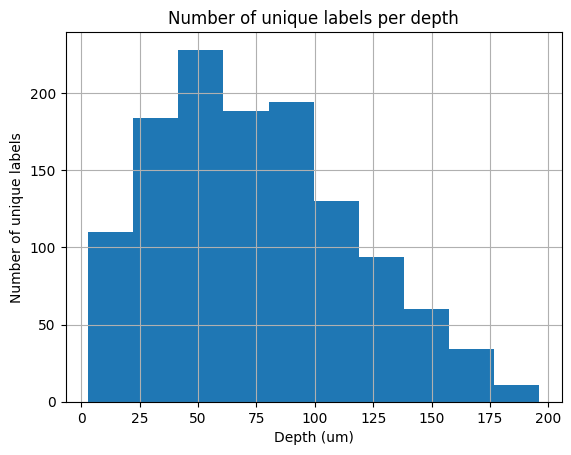

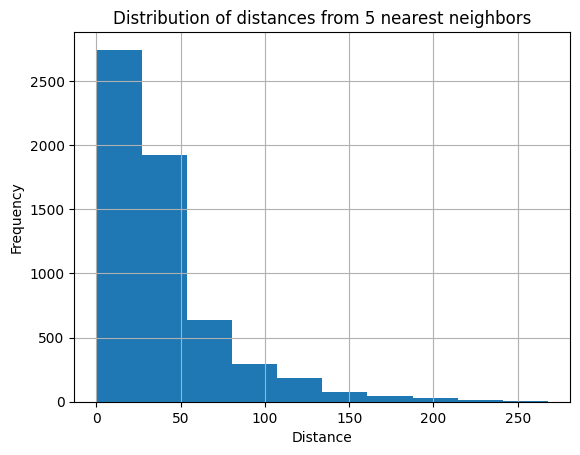

In [32]:
#Plot a histogram of the number of unique labels per depth
depth_df['depth_um'].hist()
plt.xlabel('Depth (um)')
plt.ylabel('Number of unique labels')
plt.title('Number of unique labels per depth')
plt.show()

#Plot the swarm plot of volume_um3 against depth_um
fig = px.scatter(merged_metrics_df, x='depth_um', y='volume_um3', color='sample', title='Volume (um3) vs Depth (um)')
fig.show()

#Plot the swarm plot of num_endpoints against depth_um
fig = px.scatter(merged_metrics_df, x='depth_um', y='num_endpoints', color='sample', title='Number of endpoints vs Depth (um)')
fig.show()

#Plot a histogram of distance from the k_nearest_neighbors_df
k_nearest_neighbors_df['distance'].hist()
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title(f'Distribution of distances from {nearest_neighbors} nearest neighbors')
plt.show()

In [3]:
# Load the data
df = pd.read_csv(sample_to_ramification_csv['A'])

# 1. Basic exploratory analysis
def explore_microglia_data(df):
    # Summary statistics
    print("Summary Statistics:")
    stats = df.describe()
    isfile
    # Create a figure with subplots
    fig = make_subplots(
        rows=2, 
        cols=2,
        subplot_titles=(
            "Distribution of Branch Points", 
            "Distribution of Total Skeleton Length",
            "Distribution of Longest Path Length",
            "Distribution of Average Branch Length"
        )
    )
    
    # Add histograms
    fig.add_trace(
        go.Histogram(x=df['num_branch_points'], nbinsx=20, name="Branch Points"),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Histogram(x=df['total_skeleton_length_um'], nbinsx=20, name="Total Length (μm)"),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Histogram(x=df['longest_path_length_um'], nbinsx=20, name="Longest Path (μm)"),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Histogram(x=df['avg_branch_length_um'], nbinsx=20, name="Avg Branch Length (μm)"),
        row=2, col=2
    )
    
    fig.update_layout(
        height=800, 
        width=1000,
        title_text="Distributions of Key Morphological Features",
        showlegend=False
    )
    
    return fig, stats

# 2. Correlation analysis
def correlation_analysis(df):
    # Select numeric columns for correlation
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr()
    
    # Create heatmap with Plotly
    fig = px.imshow(
        corr_matrix,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        color_continuous_scale='Viridis',
        title="Correlation Matrix of Morphological Features"
    )
    
    fig.update_layout(
        width=900,
        height=800,
        xaxis=dict(tickangle=45),
    )
    
    return fig, corr_matrix

# 3. Relationship visualization
def visualize_relationships(df):
    # Scatter plot matrix for key metrics
    key_metrics = ['num_branch_points', 'num_endpoints', 'total_skeleton_length_um', 
                  'longest_path_length_um', 'avg_branch_length_um', 'avg_tortuosity']
    
    fig = px.scatter_matrix(
        df,
        dimensions=key_metrics,
        title="Scatter Matrix of Key Morphological Metrics",
        opacity=0.7
    )
    
    fig.update_layout(
        width=1000,
        height=1000
    )
    
    return fig

# 4. 3D visualization of key parameters
def create_3d_scatter(df):
    fig = px.scatter_3d(
        df, 
        x='num_branch_points', 
        y='total_skeleton_length_um', 
        z='longest_path_length_um',
        color='avg_tortuosity',
        size='num_skeleton_nodes',
        opacity=0.7,
        title="3D Relationship Between Key Morphological Parameters"
    )
    
    fig.update_layout(
        width=900,
        height=700
    )
    
    return fig

# Function to identify and visualize potential cell clusters
def analyze_cell_clusters(df):
    # Create a scatter plot colored by branch count
    fig = px.scatter(
        df, 
        x='total_skeleton_length_um', 
        y='num_branch_points',
        size='num_skeleton_nodes',
        color='avg_tortuosity',
        hover_data=['label', 'num_endpoints', 'longest_path_length_um'],
        title="Potential Microglial Cell Clusters"
    )
    
    # Add trendline
    fig.update_layout(
        width=900,
        height=700,
        xaxis_title="Total Skeleton Length (μm)",
        yaxis_title="Number of Branch Points"
    )
    
    return fig

# For comparing across multiple volumes or conditions
def compare_conditions(df_list, condition_names):
    """
    Compare key metrics across different conditions
    
    Parameters:
    df_list: List of DataFrames, one for each condition
    condition_names: List of condition names corresponding to each DataFrame
    """
    # For demonstration, we'll create some synthetic data
    # In practice, you'd use your actual dataframes
    
    # Prepare data for plotting
    data_for_boxplot = []
    
    # Key metrics to compare
    metrics = ['num_branch_points', 'total_skeleton_length_um', 
               'longest_path_length_um', 'avg_branch_length_um', 'avg_tortuosity']
    
    # In real usage, you would iterate through your actual dataframes
    # This is just simulating multiple conditions with the same data
    for i, condition in enumerate(condition_names):
        temp_df = df.copy()  # Using same df for demo
        temp_df['condition'] = condition
        data_for_boxplot.append(temp_df)
    
    combined_df = pd.concat(data_for_boxplot)
    
    # Create box plots for each metric
    figs = []
    for metric in metrics:
        fig = px.box(
            combined_df, 
            x='condition', 
            y=metric, 
            color='condition',
            title=f"Comparison of {metric} Across Conditions",
            points="all"
        )
        figs.append(fig)
    
    return figs

# Example usage (for multiple conditions):
# condition_dfs = [df1, df2, df3]  # Your actual dataframes
# condition_names = ['Control', 'Treatment A', 'Treatment B']
# comparison_figs = compare_conditions(condition_dfs, condition_names)

In [5]:
fig, stats = explore_microglia_data(df)
fig.show()

fig, corr_matrix = correlation_analysis(df)
fig.show()

fig = visualize_relationships(df)
fig.show()

fig = create_3d_scatter(df)
fig.show()

fig = analyze_cell_clusters(df)
fig.show()

Summary Statistics:
